# Working with Cactus horizons

In this notebook, we learn how to work with horizon data. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit.simdir import SimDir

%matplotlib inline

The best way to access horizon data is from `SimDir`:

In [2]:
hor = SimDir("../../tests/horizons").horizons

print(hor)

Horizons found:
3 horizons from QuasiLocalMeasures
2 horizons from AHFinderDirect


As we see, `kuibit` found some horizons. `kuibit` looks for data from `QuasiLocalMeasures` and `AHFinderDirect`. These two thorns use different indexing systems, and, at the moment, you must provide both to uniquely indentify an horizon. If you need information from only one of the two (e.g., you want to plot the apparent horizon), you can also use the functions `get_apparent_horizon` and `get_qlm_horizon`.

In [3]:
h1 = hor[(0, 1)]
print(h1)

Formation time: 0.0000
Shape available
Final Mass = 5.538e-01
Final Angular Momentum = -3.598e-07
Final Dimensionless Spin = -1.173e-06


You can find the available indices using suitable attributes:

In [4]:
print(hor.available_qlm_horizons)
print(hor.available_apparent_horizons)

[0, 1, 2]
[1, 2]


Once an horizon is fixed, you can access all the properties from `QuasiLocalMeasures` and from `AHFinderDirect` as attributes. These are all `TimeSeries`. For example, the mass as computed by `QuasiLocalMeasures`:

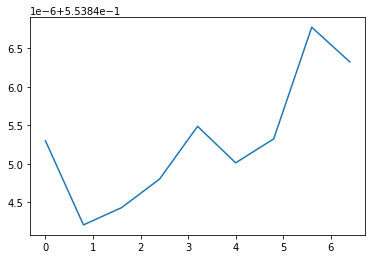

In [5]:
plt.plot(h1.mass)

For quantities from `AHFinderDirect` you have to use the `ah` namespace:

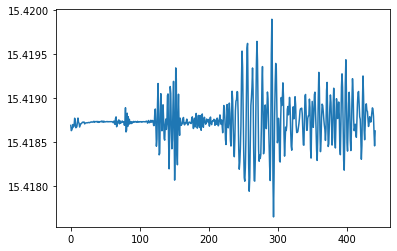

In [6]:
plt.plot(h1.ah.area)

`kuibit` can also work with shape data. `AHFinderDirect` uses multiple patches, we can plot an example in 3D:

Notebook initialized with png backend.



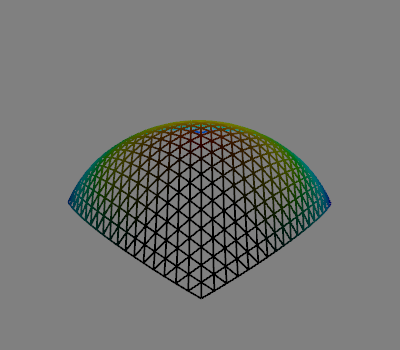

In [7]:
from mayavi import mlab
mlab.init_notebook('png')

(px, py, pz) = h1.shape_at_iteration(0)

mlab.mesh(px[0], py[0], pz[0], representation='wireframe')

If you plot all the patches, you will have the horizon in 3D.


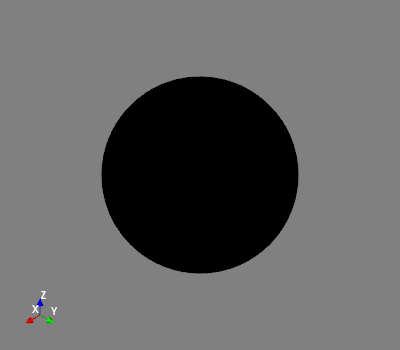

In [8]:
mlab.clf()

for pnum in range(len(px)):
    mlab.mesh(px[pnum], py[pnum], pz[pnum], color=(0, 0, 0))

# For some reasons mlab.show() doesn't produce the picture here, 
# so, there' is an additional mlab.mesh statement. This is here
# just to display the picture
mlab.orientation_axes()
mlab.mesh(px[0], py[0], pz[0], color=(0,0,0))

In case you want to work with a 2D slice, of the shape, you can use the method `shape_outline_at_iteration` and specify how to cut the shape. 

Note that the the distributions of points is not uniform across the horizon and `kuibit` does not do any interpolation across points. Therefore, there are values of `cut` that will lead to a malformed horizon. It is recommended to use cuts that are along the principal directions.

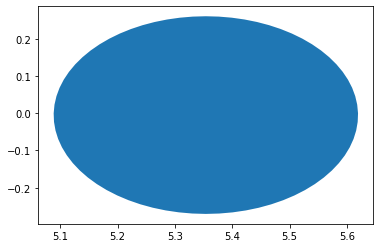

In [9]:
cut = [None, None, 0]  # Equatorial plane (z=0)

shape = h1.shape_outline_at_iteration(0, cut)

plt.fill(*shape)

You can also use the module `visualize_matplotlib` to plot the horizon in 2D. If you already have the shape, you can use `plot_horizon`.

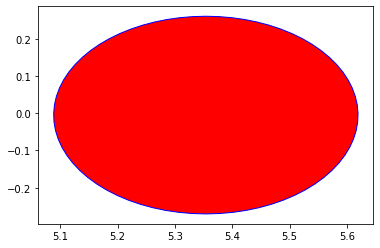

In [10]:
from kuibit import visualize_matplotlib as viz

viz.plot_horizon(shape, color='r', edgecolor='b')

Alternatively, you can use the higher level functions `plot_horizon_on_plane_at_iteration` or `plot_horizon_on_plane_at_time`. These take directly a `OneHorizon` object and the desired iteration/time.

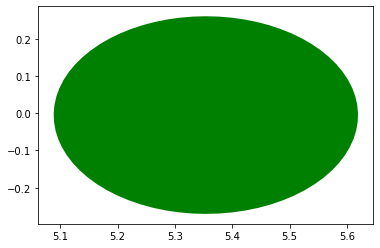

In [11]:
viz.plot_horizon_on_plane_at_time(h1, time=0, plane="xy", color='g')